In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

import os
import multiprocessing as mp
from datetime import datetime, timezone, timedelta

# Supress warnings:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import time

import tensorflow as tf
from tensorflow import keras

import random
random.seed(21)
from numpy.random import seed
np.random.seed(21)
tf.random.set_seed(21)

In [2]:
#IMPORT DATA FROM PREPROCESSING (UPDATE PATHS TO RUN)
x_train = pd.read_csv(r"C:\Users\cgrac\CMT307\x_train.csv")
y_train = pd.read_csv(r"C:\Users\cgrac\CMT307\y_train.csv")
x_val = pd.read_csv(r"C:\Users\cgrac\CMT307\x_val.csv")
y_val = pd.read_csv(r"C:\Users\cgrac\CMT307\y_val.csv")

In [3]:
x_train.head()

,sea_level_pressure,site_id_mapped_BerkeleyCA,site_id_mapped_CardiffUK,site_id_mapped_CarletonOttawaCA,site_id_mapped_CornellNY,site_id_mapped_DublinIreland,site_id_mapped_LondonUK,site_id_mapped_OrlandoFL,site_id_mapped_OttawaCA,site_id_mapped_PrincetonNJ,...,month_dttm_March,month_dttm_May,month_dttm_November,month_dttm_October,month_dttm_September,square_feet,wind_speed,hour_dttm,air_temperature,dew_temperature
0,0.500816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,-0.573547,-0.64,-0.090909,0.744737,0.900164
1,0.500816,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.103579,1.04,0.636364,0.534211,0.710311
2,-0.749184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.584865,0.20,0.727273,0.715789,0.900164
3,-0.999184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,-0.202031,-0.64,-0.727273,0.656579,0.909984
4,1.625816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.067259,0.60,-0.454545,0.290789,0.327332


In [4]:
x_train.shape

(11422446, 57)

In [5]:
#Keras Reset
keras.backend.clear_session() 

In [6]:
#BASE MODEL ELU
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(57,)))
model.add(keras.layers.Dense(10, activation= 'elu'))
model.add(keras.layers.Dense(16, activation= 'elu'))
model.add(keras.layers.Dense(1, activation= 'elu'))
model.summary()

model.compile(loss = "mean_squared_error", optimizer='adam', metrics = ["root_mean_squared_error"])

# Model training
start = time.time()
historyelu = model.fit(x_train, y_train, epochs = 10, validation_split=0.1, batch_size=512, callbacks=[early_stopping_cb])
end = time.time()
length = (end - start)/60

print(f'The model took {length} minutes to fit!')
print('The best model has the following metrics:')
model.evaluate(x_val, y_val)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 773 (3.02 KB)

 Trainable params: 773 (3.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 0.2376 - root_mean_squared_error: 0.4704 - val_loss: 0.1404 - val_root_mean_squared_error: 0.3747
Epoch 2/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step - loss: 0.1393 - root_mean_squared_error: 0.3733 - val_loss: 0.1360 - val_root_mean_squared_error: 0.3688
Epoch 3/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - loss: 0.1357 - root_mean_squared_error: 0.3684 - val_loss: 0.1336 - val_root_mean_squared_error: 0.3655
Epoch 4/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step - loss: 0.1337 - root_mean_squared_error: 0.3656 - val_loss: 0.1321 - val_root_mean_squared_error: 0.3635
Epoch 5/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step - loss: 0.1321 - root_mean_squared_error: 0.3634 - val_loss: 0.1308 - val_root_mean_squared_error: 0.3617
Epoch 6/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step - loss: 0.1309 - root_mean_squared_error: 0.3618 - val_loss: 0.1300 - val_root_mean_squared_error: 0.3605
Epoch 7/10
20079/20079

[0.1304720640182495, 0.3612091839313507]

In [7]:
#BASE MODEL ELU SCALE
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(57,)))
model.add(keras.layers.Dense(35, activation= 'elu'))
model.add(keras.layers.Dense(57, activation= 'elu'))
model.add(keras.layers.Dense(1, activation= 'elu'))
model.summary()

model.compile(loss = "mean_squared_error", optimizer='adam', metrics = ["root_mean_squared_error"])

# Model training
start = time.time()
historyeluScale = model.fit(x_train, y_train, epochs = 10, validation_split=0.1, batch_size=512, callbacks=[early_stopping_cb])
end = time.time()
length = (end - start)/60

print(f'The model took {length} minutes to fit!')
print('The best model has the following metrics:')
model.evaluate(x_val, y_val)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 35)             │         2,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 57)             │         2,052 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            58 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,140 (16.17 KB)

 Trainable params: 4,140 (16.17 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step - loss: 0.1754 - root_mean_squared_error: 0.4139 - val_loss: 0.1294 - val_root_mean_squared_error: 0.3597
Epoch 2/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - loss: 0.1256 - root_mean_squared_error: 0.3544 - val_loss: 0.1169 - val_root_mean_squared_error: 0.3419
Epoch 3/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step - loss: 0.1162 - root_mean_squared_error: 0.3409 - val_loss: 0.1112 - val_root_mean_squared_error: 0.3334
Epoch 4/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - loss: 0.1114 - root_mean_squared_error: 0.3338 - val_loss: 0.1073 - val_root_mean_squared_error: 0.3276
Epoch 5/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step - loss: 0.1078 - root_mean_squared_error: 0.3283 - val_loss: 0.1040 - val_root_mean_squared_error: 0.3224
Epoch 6/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step - loss: 0.1046 - root_mean_squared_error: 0.3234 - val_loss: 0.1009 - val_root_mean_squared_error: 0.3176
Epoch 7/10
20079/20079

[0.09576297551393509, 0.309455931186676]

In [8]:
#BASE MODEL ELU SCALE x2
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(57,)))
model.add(keras.layers.Dense(70, activation= 'elu'))
model.add(keras.layers.Dense(114, activation= 'elu'))
model.add(keras.layers.Dense(1, activation= 'elu'))
model.summary()

model.compile(loss = "mean_squared_error", optimizer='adam', metrics = ["root_mean_squared_error"])

# Model training
start = time.time()
historyeluScale2 = model.fit(x_train, y_train, epochs = 10, validation_split=0.1, batch_size=512, callbacks=[early_stopping_cb])
end = time.time()
length = (end - start)/60

print(f'The model took {length} minutes to fit!')
print('The best model has the following metrics:')
model.evaluate(x_val, y_val)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 70)             │         4,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 114)            │         8,094 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           115 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,269 (47.93 KB)

 Trainable params: 12,269 (47.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - loss: 0.1698 - root_mean_squared_error: 0.4073 - val_loss: 0.1209 - val_root_mean_squared_error: 0.3477
Epoch 2/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 0.1185 - root_mean_squared_error: 0.3442 - val_loss: 0.1097 - val_root_mean_squared_error: 0.3312
Epoch 3/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 0.1092 - root_mean_squared_error: 0.3305 - val_loss: 0.1030 - val_root_mean_squared_error: 0.3210
Epoch 4/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 0.1037 - root_mean_squared_error: 0.3220 - val_loss: 0.0992 - val_root_mean_squared_error: 0.3150
Epoch 5/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 0.0997 - root_mean_squared_error: 0.3157 - val_loss: 0.0959 - val_root_mean_squared_error: 0.3098
Epoch 6/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 0.0968 - root_mean_squared_error: 0.3112 - val_loss: 0.0938 - val_root_mean_squared_error: 0.3062
Epoch 7/10
20079/20079

[0.09138292819261551, 0.30229610204696655]

In [9]:
#BASE MODEL ELU SCALE x4
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(57,)))
model.add(keras.layers.Dense(140, activation= 'elu'))
model.add(keras.layers.Dense(228, activation= 'elu'))
model.add(keras.layers.Dense(1, activation= 'elu'))
model.summary()

model.compile(loss = "mean_squared_error", optimizer='adam', metrics = ["root_mean_squared_error"])

# Model training
start = time.time()
historyeluScale4 = model.fit(x_train, y_train, epochs = 10, validation_split=0.1, batch_size=512, callbacks=[early_stopping_cb])
end = time.time()
length = (end - start)/60

print(f'The model took {length} minutes to fit!')
print('The best model has the following metrics:')
model.evaluate(x_val, y_val)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 140)            │         8,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 228)            │        32,148 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           229 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,497 (158.19 KB)

 Trainable params: 40,497 (158.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 61s 3ms/step - loss: 0.1615 - root_mean_squared_error: 0.3985 - val_loss: 0.1142 - val_root_mean_squared_error: 0.3379
Epoch 2/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - loss: 0.1125 - root_mean_squared_error: 0.3354 - val_loss: 0.1031 - val_root_mean_squared_error: 0.3210
Epoch 3/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - loss: 0.1030 - root_mean_squared_error: 0.3209 - val_loss: 0.0970 - val_root_mean_squared_error: 0.3115
Epoch 4/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - loss: 0.0974 - root_mean_squared_error: 0.3122 - val_loss: 0.0922 - val_root_mean_squared_error: 0.3037
Epoch 5/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - loss: 0.0935 - root_mean_squared_error: 0.3058 - val_loss: 0.0901 - val_root_mean_squared_error: 0.3002
Epoch 6/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - loss: 0.0908 - root_mean_squared_error: 0.3013 - val_loss: 0.0880 - val_root_mean_squared_error: 0.2967
Epoch 7/10
20079/20079

[0.0852905660867691, 0.2920454740524292]

In [10]:
#BASE MODEL ELU SCALE x8
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(57,)))
model.add(keras.layers.Dense(280, activation= 'elu'))
model.add(keras.layers.Dense(456, activation= 'elu'))
model.add(keras.layers.Dense(1, activation= 'elu'))
model.summary()

model.compile(loss = "mean_squared_error", optimizer='adam', metrics = ["root_mean_squared_error"])

# Model training
start = time.time()
historyeluScale8 = model.fit(x_train, y_train, epochs = 10, validation_split=0.1, batch_size=512, callbacks=[early_stopping_cb])
end = time.time()
length = (end - start)/60

print(f'The model took {length} minutes to fit!')
print('The best model has the following metrics:')
model.evaluate(x_val, y_val)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 280)            │        16,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 456)            │       128,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           457 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144,833 (565.75 KB)

 Trainable params: 144,833 (565.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 95s 5ms/step - loss: 0.1585 - root_mean_squared_error: 0.3948 - val_loss: 0.1109 - val_root_mean_squared_error: 0.3330
Epoch 2/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 92s 5ms/step - loss: 0.1087 - root_mean_squared_error: 0.3296 - val_loss: 0.0994 - val_root_mean_squared_error: 0.3153
Epoch 3/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 90s 4ms/step - loss: 0.0995 - root_mean_squared_error: 0.3154 - val_loss: 0.0938 - val_root_mean_squared_error: 0.3062
Epoch 4/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 91s 5ms/step - loss: 0.0945 - root_mean_squared_error: 0.3074 - val_loss: 0.0904 - val_root_mean_squared_error: 0.3007
Epoch 5/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 91s 5ms/step - loss: 0.0913 - root_mean_squared_error: 0.3022 - val_loss: 0.0875 - val_root_mean_squared_error: 0.2958
Epoch 6/10
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 92s 5ms/step - loss: 0.0890 - root_mean_squared_error: 0.2984 - val_loss: 0.0856 - val_root_mean_squared_error: 0.2926
Epoch 7/10
20079/20079

[0.08469852805137634, 0.2910301089286804]

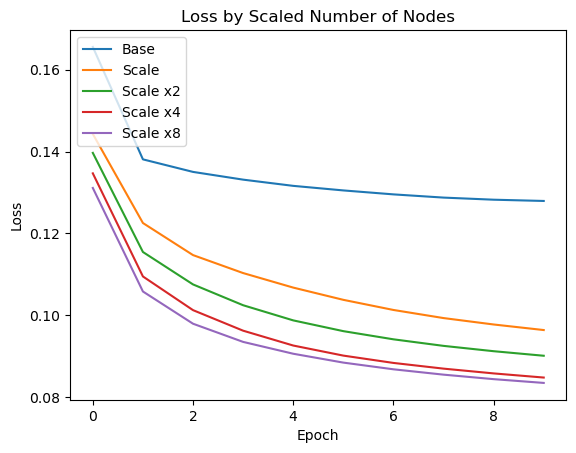

In [11]:
import matplotlib.pyplot as plt

plt.plot(historyelu.history['loss'])
plt.plot(historyeluScale.history['loss'])
plt.plot(historyeluScale2.history['loss'])
plt.plot(historyeluScale4.history['loss'])
plt.plot(historyeluScale8.history['loss'])
plt.title('Loss by Scaled Number of Nodes')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Base', 'Scale', 'Scale x2', 'Scale x4', 'Scale x8'], loc='upper left')
plt.show()